In [1]:
import numpy as np 
import random as rd
import matplotlib.pyplot as plt
from scipy.stats import norm

## Method 1: analytical formula

In [2]:
def BB(t1, t2):
    return 1/k*(1-np.exp(-k*(t2-t1)))

def bond_price (T1, T2, r, theta, sigma, k): ## function for determing bond price
    b = BB(T1,T2) #1/k*(1-np.exp(-k*(T2-T1)))
    A = np.exp((theta - sigma**2 / (2 * k**2)) * \
               (b-(T2-T1))-sigma**2/(4*k) * b**2)
    return A*np.exp(-b * r)

In [3]:
strike = 0.805
k = 0.15
sigma_r = 0.01
theta = 0.05
r0 = 0.042
T1 = 0.25 # 3 months expiration date put option
T2 = 5.25

sigma_t = sigma_r*np.sqrt((1-np.exp(-2*k*T1))/(2*k))* BB(T1,T2)
h= 1 / sigma_t*np.log(bond_price(0,T2,r0,theta,sigma_r,k) / (strike*bond_price(0,T1,r0,theta,sigma_r,k))) + sigma_t/2

In [4]:
price_1 = strike * bond_price(0,T1,r0,theta,sigma_r,k) * \
            norm.cdf(-h+sigma_t) - bond_price(0,T2,r0,theta,sigma_r,k) * norm.cdf(-h)

In [5]:
 print('Price of ZBP using the analytical formula is\n', price_1)

Price of ZBP using the analytical formula is
 0.0074897997038153585


### Method 2: Solving the PDE

In [6]:
def maxx(a): # finctipn which compute max(0,a(i)) for each a(i) in a
    res = np.array([])
    for k in range(0,len(a)):
        if a[k] > 0:
            res = np.append(res,a[k])
        else:
            res = np.append(res,0)
    return res

In [11]:
price_2 = []

r_density = np.arange(100,1000,5)

# r boundaries
[r_min, r_max] = [0, 1]

dt = 0.001 # time step

t_grid = np.arange(0,T1,dt)

for ri in r_density:
    
    dr = 1/ri
    
    r_grid = np.arange(r_min,r_max,dr)
    
    V = np.zeros((len(t_grid),len(r_grid)))
    
    # A B and C:
    A = dt * ( - k * (theta - r_grid[1:len(r_grid)-2]) / (2 * dr) \
            + sigma_r**2 / (2 * dr**2) )
    B = 1 - sigma_r**2 * dt / dr**2  -  dt * r_grid[1:len(r_grid)-2]
    C = A + dt/dr * k * (theta-r_grid[1:len(r_grid)-2])
    
    V[len(t_grid)-1,:] = maxx(strike - bond_price(T1, T2, r_grid, theta, sigma_r, k))
    
    # set teh first and last column manually
    V[:, 0] = strike - bond_price(T1, T2, 0, theta, sigma_r, k)
    V[:, len(r_grid)-1] = 0
    
    for t in range(len(t_grid)-2,-1,-1):
        V[t, 1:len(r_grid)-2] = A * V[t+1, 0:len(r_grid)-3] + \
                                B * V[t+1, 1:len(r_grid)-2] + \
                                C * V[t+1, 2:len(r_grid)-1]
        
    r_grid_down = r_grid[np.where(r_grid < r0)[0][-1]]
    r_grid_up = r_grid[np.where(r_grid > r0)[0][0]]
    
    v_down = V[0, np.where(r_grid < r0)[0][-1]]
    v_up = V[0, np.where(r_grid > r0)[0][0]]
    
    price_2 += [v_down+(v_up-v_down)*(r0-r_grid_down)/(r_grid_up-r_grid_down)]

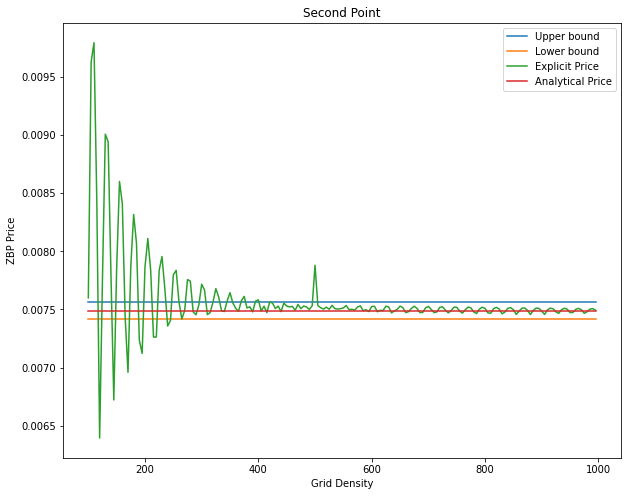

In [12]:
plt.figure(figsize=(10,8))
plt.plot(r_density,len(r_density)*[1.01*price_1], label = 'Upper bound')
plt.plot(r_density,len(r_density)*[0.99*price_1], label = 'Lower bound')
plt.plot(r_density,price_2, label = 'Explicit Price')
plt.plot(r_density,len(r_density)*[price_1],label = 'Analytical Price')
plt.legend()
plt.xlabel("Grid Density")
plt.ylabel("ZBP Price")
plt.title('Second Point')
plt.show()